In [1]:
# If you don't already have it...
import sys
#!{sys.executable} -m pip install nflows
!{sys.executable} -m pip install uproot

Defaulting to user installation because normal site-packages is not writeable
distutils: /home/epp/phrrkw/.local/lib/python3.9/site-packages
sysconfig: /home/epp/phrrkw/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None


### Trying to flow from a Gaussian to the LHCb Log10(IP) shape

* The LHCb simulation log10(IP) shape is kinda Gaussian. We want to flow from a Gaussian to there.
* The step after that would be to invert the flow (that is part of their properties), from there to Gaussian.
* A similar flow should be able to flow from Gaussian -> Z IP data shape. 
* Thus you have a 2-step flow procedure of simulation -> Gaussian -> data, which is the transformation we want to learn.

In [2]:
# Let's first load up the simulated data and put it into a 1D numpy array
import numpy as np
import uproot

file = uproot.open("../data/tuple_for_training__DATA.root")
muon_prefix = "mup_"
branch = f'{muon_prefix}IP'
selection = "(1>0)"
sim_ip = file['DecayTree'].arrays(
    branch, cut=selection, library='np')[branch].astype(np.float64)

sim_log10_ip = np.log10(sim_ip)

In [3]:
import matplotlib.pyplot as plt

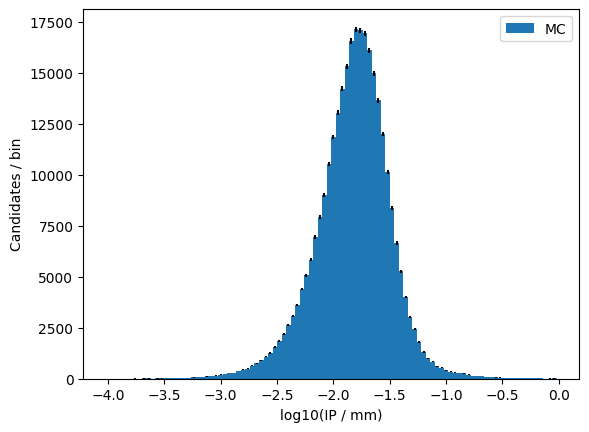

In [8]:
fig, ax = plt.subplots()
hist_mc, bins = np.histogram(sim_log10_ip, bins=100, range=(-4, 0))
bin_centers = (bins[:-1] + bins[1:]) / 2
ax.bar(x=bins[:-1], height=hist_mc, yerr=np.sqrt(hist_mc), width=bins[1] - bins[0], label='MC')
ax.set_xlabel('log10(IP / mm)')
ax.set_ylabel('Candidates / bin')
ax.legend()
plt.show()
